## Training and visualizing the Diffusion model

This notebook trains a diffusion model using visuo-tactile information from a soft-bubble sensor. The implementation is from Hugginface and can be found at [link](https://huggingface.co/blog/annotated-diffusion).

In the directory *model* you can find all the different files with the code use in this notebook. I'll try to explain each step taken as we move forward.

We first import some usefull libraries:

In [6]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F


import numpy as np

### Parts of a Diffusion model:
- Initial distribution: q(x_0) from real data.
- Target distribution: Pure gaussian noise. N(0,sigma*I)
- Beta/variance schedule.
- U-net block.
- Attention
- 
-

Let's define first the beta schedule for a toy example. The example uses a linear scheduler (not recommended) and a timestep of 300.

In [4]:
from model.beta_schedule import linear_beta_schedule


timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

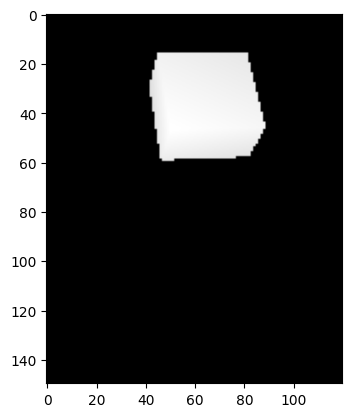

In [9]:
dataset_dir = "../datasets/datasets/toy_dataset/serious_toy1/"
img_dir = "scene_test/depth_gt/depth_data/depth_000111.npy"

image = np.load(dataset_dir + img_dir)

plt.imshow(image, cmap='gray_r')
plt.show()

In [38]:
from torchvision.transforms import Compose, ToTensor, Lambda


transform = Compose([
    ToTensor(), # turn into torch Tensor of shape CHW
])

reverse_transform = Compose([
    Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    Lambda(lambda t: t.detach().cpu().numpy())
])

x_start = transform(image).unsqueeze(0)
x_reversed = reverse_transform(x_start.squeeze(0))

print(x_start.shape)
print(x_reversed.shape)

torch.Size([1, 1, 150, 120])
(150, 120, 1)


In [41]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze(0))

  return noisy_image

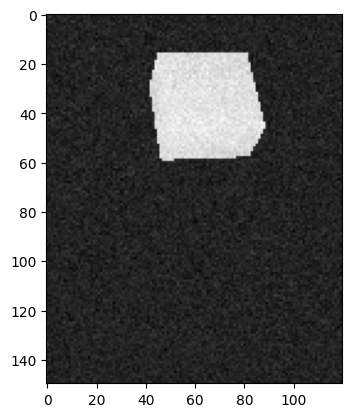

In [43]:
t = torch.tensor([40])

noise_img = get_noisy_image(x_start, t)

plt.imshow(noise_img, cmap='gray_r')
plt.show()

In [46]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(img, cmap='gray_r')
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [47]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [48]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss